# INM706 Coursework

- Benjamin Dwumah
- Rachana Shantappa Bhankur



**Run and tested on Google Cloud Platform (GCP)**

## Image Captioning With MS Coco Dataset
In this project, we use ResNet50 and LSTM to design and train a convolutional neural network + recurrent neural network model to automatically generate image captions. The encoder will be CNN, which will extract image features, and the decoder will be RNN, which will model language up to the word level. The network is trained on the MS COCO (Microsoft Common Objects in Context) dataset.

In [8]:
# Import modules
import os
import sys
sys.path.append('/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
%matplotlib inline

## Visualize the dataset

To visualize the data, we begin by initializing the COCO API that you will use to obtain the data which is the images and the annotations. Then, we'll plot a random image from the dataset, along with its five corresponding captions. Each time you run the code cell below, a different image is selected.

In the project, we will use this dataset to train our own model to generate captions from images.

In [22]:
# initialize COCO API for instance annotations
datasetDir = '../INM706/coco'
datasetType = 'val2017'
instances_annFile = os.path.join(datasetDir, 'annotations/instances_{}.json'.format(datasetType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(datasetDir, 'annotations/captions_{}.json'.format(datasetType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=1.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000431876.jpg


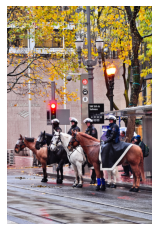

The cops in the city are riding horses threw the streets. 
an image of horses that are standing on the sidewalk
a group of people on some horses that are standing on a road.
Four cops on the back of horses stand in the street.
Several mounted police officers and their horses line up on the street. 


In [134]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id'])
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Explore Data Loader

We have already written a [data loader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) that you can use to load the COCO dataset in batches. 

In the code cell below, we will initialize the data loader by using the `get_loader` function in **dataLoader.py**.  


The `get_loader` function takes as input a number of arguments that can be explored in **data_loader.py**. Most of the arguments must be left at their default values, and we are only allowed to amend the values of the arguments below:
1. **`transform`** - an [image transform](http://pytorch.org/docs/master/torchvision/transforms.html) specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder.  For now, we will keep the transform as provided in `transform_train`.  We will have the opportunity later to choose our own image transform to pre-process the COCO images.
2. **`mode`** - one of `'train'` (loads the training data in batches) or `'test'` (for the test data). We will say that the data loader is in training or test mode, respectively. 
3. **`batch_size`** - determines the batch size.  When training the model, this is number of image-caption pairs used to amend the model weights in each training step.
4. **`vocab_threshold`** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary.  Words that have fewer than `vocab_threshold` occurrences in the training captions are considered unknown words. 
5. **`vocab_from_file`** - a Boolean that decides whether to load the vocabulary from file.  

We will describe the `vocab_threshold` and `vocab_from_file` arguments in more detail soon.

In [9]:
import sys
import nltk
nltk.download('punkt')
from dataLoader import get_loader
from torchvision import transforms
import torch.utils.data as data

[nltk_data] Downloading package punkt to /home/bdwumah74/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=2.34s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:12<00:00, 8169.84it/s]


The data loader was stored in the variable `data_loader`. We can access the corresponding dataset as `data_loader.dataset`.  This dataset is an instance of the `CoCoDataset` class in **data_loader.py**. 

### Exploring the `__getitem__` Method

The `__getitem__` method in the `CoCoDataset` class determines how an image-caption pair is pre-processed before being incorporated into a batch.  This is true for all `Dataset` classes in PyTorch. When the data loader is in training mode, this method begins by first obtaining the filename (`path`) of a training image and its corresponding caption (`caption`).

- Image Pre-Processing: is relatively straightforward (from the `__getitem__` method in the `CoCoDataset` class). The image is converted to a tensor and preprocessed using **`transform`**


- Caption Pre-Processing: The captions also need to be pre-processed and prepped for training. In this notebook, for generating captions, we are aiming to create a model that predicts the next token of a sentence from previous tokens, so we turn the caption associated with any image into a list of tokenized words, before casting it to a PyTorch tensor that we can use to train the network.

In [7]:
# Convert every letter in the caption to lowercase, 
# and the nltk.tokenize.word_tokenize function is used to obtain a list of string-valued tokens. 
sample_caption = 'Three lions standing on a dry grass'
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['three', 'lions', 'standing', 'on', 'a', 'dry', 'grass']


We initialize an empty list and append an integer to mark the start of a caption.  The paper [(Oriol et al., 2015)](https://arxiv.org/pdf/1411.4555.pdf) that we took inspiration to implement uses a special start word (and a special end word, which we'll examine below) to mark the beginning and end of a caption.

This special start word (`"<start>"`) is decided when instantiating the data loader and is passed as a parameter (`start_word`).  One is **required** to keep this parameter at its default value (`start_word="<start>"`).

As you will see below, the integer `0` is always used to mark the start of a caption.

In [8]:
# Initialize empty caption list
sample_caption = []

# Append special start word
start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)

# Append integer value of start word
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In [9]:
# Add integers that correspond to each of the tokens in the caption.
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 263, 6108, 330, 49, 3, 2130, 168]


In [10]:
# Append special end word
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

# Append integer value of end word
sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 263, 6108, 330, 49, 3, 2130, 168, 1]


In [11]:
# Convert the list of integers to a PyTorch tensor and cast it to long type
sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,  263, 6108,  330,   49,    3, 2130,  168,    1])


In order to convert a token to its corresponding integer, we call `data_loader.dataset.vocab` as a function.  The details of how this call works can be explored in the `__call__` method in the `Vocabulary` class in **vocabulary.py**.  

```python
def __call__(self, word):
    if not word in self.word2idx:
        return self.word2idx[self.unk_word]
    return self.word2idx[word]
```

The `word2idx` instance variable is a Python dictionary that is indexed by string-valued keys (mostly tokens obtained from training captions). For each key, the corresponding value is the integer that the token is mapped to in the pre-processing step.

In [12]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'bicycle': 4,
 'replica': 5,
 'with': 6,
 'clock': 7,
 'as': 8,
 'the': 9}

In [13]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9438


As you will see if you examine the code in **vocabulary.py**, the `word2idx` dictionary is created by looping over the captions in the training dataset.  If a token appears no less than `vocab_threshold` times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer.  We have the option later to amend the `vocab_threshold` argument when instantiating the data loader.  Note that in general, **smaller** values for `vocab_threshold` yield a **larger** number of tokens in the vocabulary.

In [14]:
# Modify the minimum word count threshold.
vocab_threshold = 6

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:09<00:00, 8490.79it/s]


In [15]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9438


There are also a few special keys in the `word2idx` dictionary.  We are already familiar with the special start word (`"<start>"`) and special end word (`"<end>"`).  There is one more special token, corresponding to unknown words (`"<unk>"`).  All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

In [16]:
# Append special unknown word
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

# Append integer value of unknown word
print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


In [17]:
# Test for unknown words in vocabulary
print(data_loader.dataset.vocab('wqedasfs'))
print(data_loader.dataset.vocab('fslsalss'))

2
2


## DataLoader from File

The final thing to mention is the `vocab_from_file` argument that is supplied when creating a data loader.  To understand this argument, note that when you create a new data loader, the vocabulary (`data_loader.dataset.vocab`) is saved as a pickle file in the project folder, with filename `vocab.pkl`.
 

We only need to run the data loader *one more time* with the chosen `vocab_threshold` to save the new vocabulary to file.  Then, we can henceforth set `vocab_from_file=True` to load the vocabulary from file and speed the instantiation of the data loader.  Note that building the vocabulary from scratch is the most time-consuming part of instantiating the data loader, and so we set `vocab_from_file=True`.

Note that if `vocab_from_file=True`, then any supplied argument for `vocab_threshold` when instantiating the data loader is completely ignored.

In [18]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:08<00:00, 8652.27it/s]


## Using DataLoader to obtain batches
The captions in the dataset vary greatly in length. One can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).  

In the code cell below, we use this list to print the total number of captions in the training data with each length.  As you will see below, the majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

In [19]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 123316
value: 11 --- count: 114543
value:  9 --- count: 102606
value: 12 --- count: 82271
value: 13 --- count: 53723
value: 14 --- count: 31924
value:  8 --- count: 29696
value: 15 --- count: 18511
value: 16 --- count: 11022
value: 17 --- count:  6928
value: 18 --- count:  4382
value: 19 --- count:  2890
value:  7 --- count:  2297
value: 20 --- count:  2047
value: 21 --- count:  1443
value: 22 --- count:   978
value: 23 --- count:   746
value: 24 --- count:   563
value: 25 --- count:   390
value: 26 --- count:   287
value: 27 --- count:   212
value: 28 --- count:   162
value: 29 --- count:   124
value: 30 --- count:    92
value: 31 --- count:    80
value: 32 --- count:    61
value: 34 --- count:    51
value: 33 --- count:    45
value: 37 --- count:    43
value: 35 --- count:    42
value: 36 --- count:    32
value: 38 --- count:    27
value: 39 --- count:    25
value: 43 --- count:    23
value: 44 --- count:    21
value: 40 --- count:    18
value: 45 --- count:    1

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  This approach for assembling batches matches the procedure in [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) and has been shown to be computationally efficient without degrading performance. The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`. Each time you run the code cell above, a different caption length is sampled, and a different batch of training data is returned.

In [20]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
print('images:', images)
print('captions:', captions)

sampled indices: [504711, 439255, 388070, 153377, 509197, 298, 272396, 261377, 241383, 476586]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 11])
images: tensor([[[[ 0.9646,  0.8276,  0.7762,  ..., -2.1008, -2.0665, -2.0494],
          [ 1.0331,  1.0844,  1.1358,  ..., -2.0665, -2.0837, -2.0837],
          [ 0.9303,  0.9817,  1.0673,  ..., -2.0494, -2.0837, -2.0837],
          ...,
          [ 0.1939, -0.2684,  0.1254,  ..., -2.0837, -2.0665, -2.0152],
          [ 0.0398,  0.0227,  0.0227,  ..., -2.1008, -2.0665, -1.9980],
          [ 0.0741,  0.0398,  0.1768,  ..., -2.0837, -2.1008, -2.0323]],

         [[-1.3354, -1.3354, -1.2829,  ..., -1.8782, -1.8782, -1.9132],
          [-1.2654, -1.3704, -1.3529,  ..., -1.9307, -1.9307, -1.9307],
          [-1.5105, -1.5455, -1.4580,  ..., -2.0007, -1.9657, -1.9307],
          ...,
          [-1.5455, -1.6506, -1.5455,  ..., -1.3529, -1.4580, -1.3354],
          [-1.6331, -1.6331, -1.4580,  ..., -1.3704, -1.4755, -1

## Experiment with CNN Encoder

We weill implement a rough patch of the CNN-RNN architecture towards the goal of image captioning before starting the actual training

In [10]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Device for Pytorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##### Instantiate the CNN encoder in encoder
The pre-processed images from the batch are passed through the encoder, and the output is stored in `features`. The encoder that we used is a pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding. We incorporate a pre-trained CNN into the encoder.  The `EncoderCNN` class takes `embed_size` as an input argument, which will also correspond to the dimensionality of the input to the RNN decoder that we will implement later on. 

In [23]:
# Specify the dimensionality of the image embedding.
embed_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that the encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 512])


##### Implement the RNN Decoder

The decoder implemented is a copy of  [Oriol et al., 2015](https://arxiv.org/pdf/1411.4555.pdf), which uses at least one RNN layer, with hidden dimension `hidden_size`.

The decoder will be an instance of the `DecoderRNN` class and must accept as input:
- the PyTorch tensor `features` containing the embedded image features (when the last batch of images was passed through `encoder`), along with
- a PyTorch tensor corresponding to the last batch of captions (`captions`).

Note that the way we have written the data loader should simplify the code a bit.  In particular, every training batch will contain pre-processed captions where all have the same length (`captions.shape[1]`), so **we do not need to worry about padding**.

In [24]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that the decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 11, 9438])


## Training Setup

We will customize the training of our CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values we set now will be used when training our model. 

We begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend `num_epochs=5`. [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but we'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if we want our model to compete with current research, we will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that we **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  We have to keep this at its default value of `100` to avoid clogging the notebook
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

In [66]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [26]:
import math
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:09<00:00, 8453.73it/s]


## Train the model

In [ ]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./INM706/models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./INM706/models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/5], Step [200/18493], Loss: 3.5681, Perplexity: 35.44774
Epoch [1/5], Step [400/18493], Loss: 3.7884, Perplexity: 44.18768
Epoch [1/5], Step [600/18493], Loss: 3.2015, Perplexity: 24.5703
Epoch [1/5], Step [800/18493], Loss: 2.8650, Perplexity: 17.5486
Epoch [1/5], Step [1000/18493], Loss: 3.1376, Perplexity: 23.0484
Epoch [1/5], Step [1200/18493], Loss: 2.6991, Perplexity: 14.8661
Epoch [1/5], Step [1400/18493], Loss: 2.8780, Perplexity: 17.7792
Epoch [1/5], Step [1600/18493], Loss: 2.7411, Perplexity: 15.5042
Epoch [1/5], Step [1800/18493], Loss: 2.6037, Perplexity: 13.5132
Epoch [1/5], Step [2000/18493], Loss: 2.7414, Perplexity: 15.5082
Epoch [1/5], Step [2200/18493], Loss: 2.5198, Perplexity: 12.4266
Epoch [1/5], Step [2400/18493], Loss: 3.0138, Perplexity: 20.36485
Epoch [1/5], Step [2600/18493], Loss: 3.0944, Perplexity: 22.0747
Epoch [1/5], Step [2800/18493], Loss: 2.5887, Perplexity: 13.3122
Epoch [1/5], Step [3000/18493], Loss: 2.4454, Perplexity: 11.5354
Epoch [1/5]

## Plot Results

Now that the training is done, we can load the training log text file and plot the results to see how the model performed. The model was trained on just 5 epochs so we do not really have a strict requirement on its performance. We will plot the following features:

- `loss`: it indicates how well the model fits the training data.
- `perplexity`: a measurement of how well a probability model predicts a sample

In [39]:
# Load training log text file into a list
with open('training_log.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    file.close()

# Extract loss and perplexity from each line
loss = []
perplexity = []
for line in lines:
    loss_idx = line.find('Loss')                        # Find index of Loss
    loss.append(float(line[loss_idx+6:loss_idx+12]))    # Slice loss value with Loss index
    
    perplexity_idx = line.find('Perplexity')
    perplexity.append(float(line[perplexity_idx+12:]))

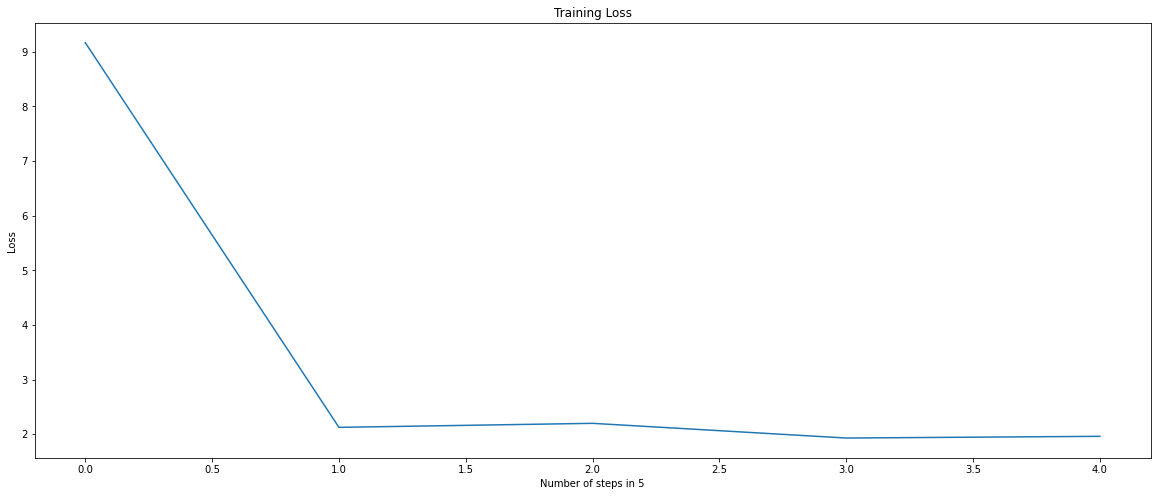

In [40]:
# Change loss and perplexity to arrays for easy plotting
loss = np.array([loss[0], loss[18493], loss[36986], loss[55479], loss[-1]])
perplexity = np.array([perplexity[0], perplexity[18493], perplexity[36986], perplexity[55479], perplexity[-1]])

# Plot training loss and save figure
plt.plot(loss)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Training Loss')
plt.xlabel('Number of steps in 5')
plt.ylabel('Loss')
plt.savefig('Training Loss')
plt.show()

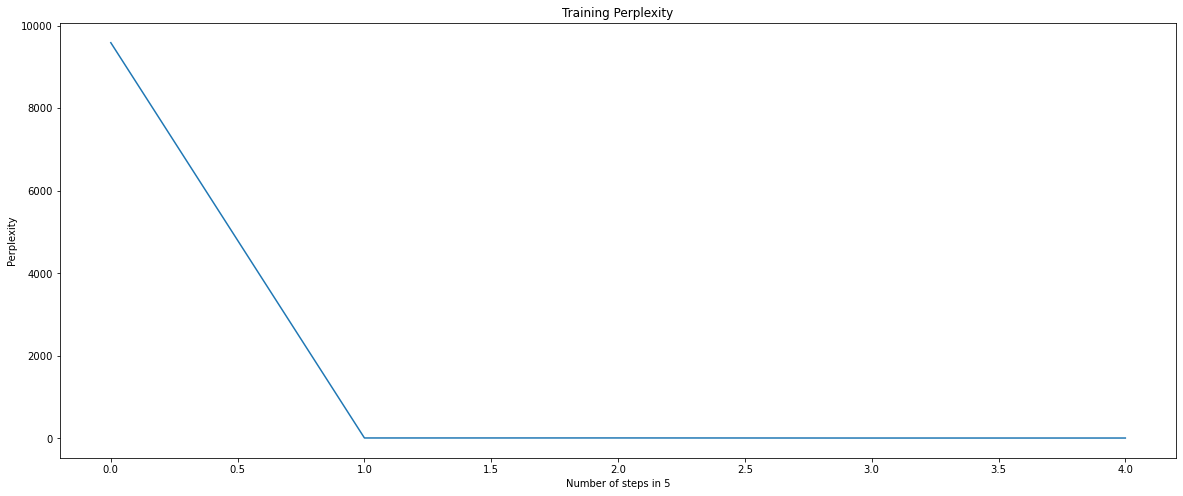

In [41]:
# Plot training perplexity and save figure
plt.plot(perplexity)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Training Perplexity')
plt.xlabel('Number of steps in 5')
plt.ylabel('Perplexity')
plt.savefig('Training Perplexity')
plt.show()

## Model Evaluation and Testing
To get a clear understanding of our model, we used BLEU and Meteor score metric to evaluate our model. We also tested our trained model on a few captions to see its performance. We loaded the a new **data_loader** with the mode test to get the test data. Then we load our saved encoder and decoder to run the images and caption them

In [13]:
# Load evaluation metrics
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
from nltk.translate.meteor_score import meteor_score

# Define a transform to pre-process the test images.
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='test',
                         batch_size=1)

Vocabulary successfully loaded from vocab.pkl file!


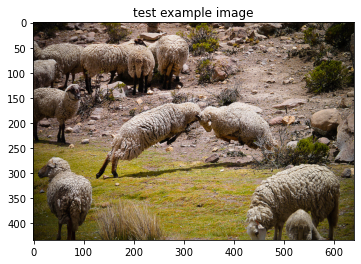

In [14]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('test example image')
plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the saved models to load.
encoder_file = 'encoder-1.pkl' 
decoder_file = 'decoder-1.pkl'

# Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('../INM706/models/', encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('../INM706/models/', decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(9438, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9438, bias=True)
)

In [16]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
print("image.shape: ", image.shape)
features = encoder(image).unsqueeze(1)
print("features.shape: ", features.shape)
print()

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('test example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that in"

image.shape:  torch.Size([1, 3, 224, 224])
features.shape:  torch.Size([1, 1, 512])

test example output: [0, 3, 152, 123, 1351, 330, 39, 3, 150, 12, 1]


In [17]:
# Complete the function.
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [18]:
sentence = clean_sentence(output)
print('Test example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

Test example sentence: A group of zebras standing in a field .


In [19]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

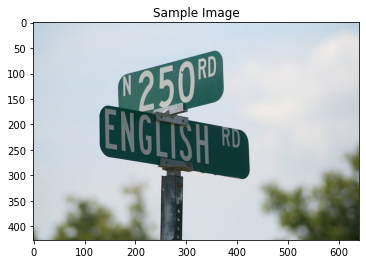

A street sign on a pole on a city street .


In [22]:
get_prediction()

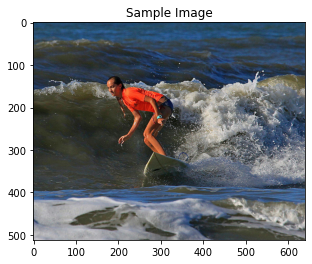

A man riding a wave on a surfboard .


In [31]:
get_prediction()

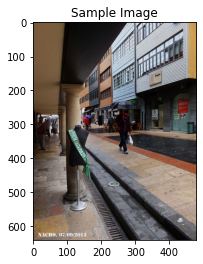

A city bus driving down a street next to a building .


In [32]:
get_prediction()

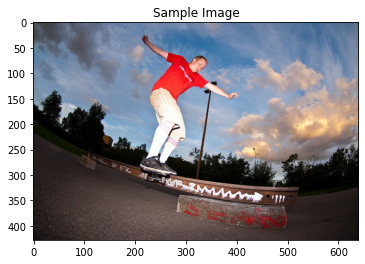

A man on a snowboard performing a trick .


In [33]:
get_prediction()

In [27]:
# Initilize list to append metric values
bleu_score_1_vals, bleu_score_2_vals, bleu_score_3_vals, bleu_score_4_vals, bleu_score_5_vals, m_score_vals = [], [], [], [], [], [] 


# Evaluate the validation set using the above metrics
for i in range(5000):
    # Load a random image from val2017
    cocoapi_loc='../INM706/coco'
    img_folder = os.path.join(cocoapi_loc, 'images/val2017/')
    ann_id = np.random.choice(ids)
    img_id = coco.anns[ann_id]['image_id']
    img = coco.loadImgs(img_id)[0]
    path = coco.loadImgs(img_id)[0]['file_name']
    image = Image.open(os.path.join(img_folder, path)).convert('RGB')
    annIds = coco_caps.getAnnIds(imgIds=img['id'])
    anns = coco_caps.loadAnns(annIds)
    
    # Load the caption of the image
    captions = [anns[i]['caption'].split() for i in range(len(anns))]
    
    # transform image to tensor
    image = transform_test(image)
    
    # change tensor to 4D
    image = torch.reshape(image, (1,3,224,224))
    
    # Feed tensor to the encoder and decoder
    image = image.to(device)            
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    
    # Get predicted caption
    sentence = (clean_sentence(output))
    sentence = sentence.split()
    
    # Get accuracy with various metrics
    smooth_func = SmoothingFunction().method1
    bleu_score_5 = round(sentence_bleu(captions, sentence, weights=(1./5., 1./5., 1./5., 1./5., 1./5.), smoothing_function=smooth_func), 2)
    bleu_score_2 = round(sentence_bleu(captions, sentence, weights=(1./2., 1./2.), smoothing_function=smooth_func), 2)
    bleu_score_3 = round(sentence_bleu(captions, sentence, weights=(1./3., 1./3., 1./3.), smoothing_function=smooth_func), 2)
    bleu_score_1 = round(sentence_bleu(captions, sentence, weights=(1, 0, 0, 0), smoothing_function=smooth_func), 2)
    bleu_score_4 = round(sentence_bleu(captions, sentence, weights=(1./4., 1./4., 1./4., 1./4.), smoothing_function=smooth_func), 2)
    m_score = round(meteor_score(captions, sentence),2)
    
    # Append accuracy values
    bleu_score_1_vals.append(bleu_score_1)
    bleu_score_2_vals.append(bleu_score_2)
    bleu_score_3_vals.append(bleu_score_3)
    bleu_score_4_vals.append(bleu_score_4)
    bleu_score_5_vals.append(bleu_score_5)
    m_score_vals.append(m_score)
    
    print('Step:', i, 'BLEU-1:', bleu_score_1, 'BLEU-2:', bleu_score_2, 'BLEU-3:', bleu_score_3, 'BLEU-4:', bleu_score_4, 'BLEU-5:', bleu_score_5, 'Meteor:', m_score, '\n') 
    

Step: 0 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 1 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.21 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.4 

Step: 2 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 3 BLEU-1: 0.42 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.34 

Step: 4 BLEU-1: 0.91 BLEU-2: 0.6 BLEU-3: 0.43 BLEU-4: 0.32 BLEU-5: 0.17 Meteor: 0.79 

Step: 5 BLEU-1: 0.67 BLEU-2: 0.55 BLEU-3: 0.49 BLEU-4: 0.45 BLEU-5: 0.4 Meteor: 0.46 

Step: 6 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.2 

Step: 7 BLEU-1: 0.55 BLEU-2: 0.47 BLEU-3: 0.42 BLEU-4: 0.31 BLEU-5: 0.17 Meteor: 0.43 

Step: 8 BLEU-1: 0.2 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.14 

Step: 9 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.32 

Step: 10 BLEU-1: 0.82 BLEU-2: 0.76 BLEU-3: 0.68 BLEU-4: 0.53 BLEU-5: 0.41 Meteor: 0.71 

Step: 11 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.

Step: 94 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.35 

Step: 95 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.23 

Step: 96 BLEU-1: 0.58 BLEU-2: 0.4 BLEU-3: 0.25 BLEU-4: 0.12 BLEU-5: 0.07 Meteor: 0.4 

Step: 97 BLEU-1: 0.33 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.31 

Step: 98 BLEU-1: 0.56 BLEU-2: 0.08 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.17 

Step: 99 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.55 BLEU-4: 0.47 BLEU-5: 0.38 Meteor: 0.52 

Step: 100 BLEU-1: 0.36 BLEU-2: 0.27 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.34 

Step: 101 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.49 

Step: 102 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 103 BLEU-1: 0.89 BLEU-2: 0.47 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.06 Meteor: 0.44 

Step: 104 BLEU-1: 0.73 BLEU-2: 0.38 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.29 

Step: 105 BLEU-1: 0.3 B

Step: 186 BLEU-1: 0.38 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.25 

Step: 187 BLEU-1: 0.54 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.19 

Step: 188 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.16 

Step: 189 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.35 

Step: 190 BLEU-1: 0.38 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.24 

Step: 191 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.38 

Step: 192 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.2 

Step: 193 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.4 

Step: 194 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.32 

Step: 195 BLEU-1: 0.58 BLEU-2: 0.46 BLEU-3: 0.35 BLEU-4: 0.26 BLEU-5: 0.14 Meteor: 0.52 

Step: 196 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 197 BLEU-

Step: 279 BLEU-1: 0.69 BLEU-2: 0.54 BLEU-3: 0.47 BLEU-4: 0.38 BLEU-5: 0.3 Meteor: 0.5 

Step: 280 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 281 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 282 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.19 

Step: 283 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.35 

Step: 284 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.17 

Step: 285 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.33 BLEU-4: 0.26 BLEU-5: 0.15 Meteor: 0.53 

Step: 286 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.38 

Step: 287 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.16 

Step: 288 BLEU-1: 0.23 BLEU-2: 0.04 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.16 

Step: 289 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.19 

Step: 290 BLEU-

Step: 371 BLEU-1: 0.5 BLEU-2: 0.39 BLEU-3: 0.34 BLEU-4: 0.24 BLEU-5: 0.13 Meteor: 0.33 

Step: 372 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.17 

Step: 373 BLEU-1: 0.46 BLEU-2: 0.2 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.34 

Step: 374 BLEU-1: 0.64 BLEU-2: 0.44 BLEU-3: 0.35 BLEU-4: 0.27 BLEU-5: 0.15 Meteor: 0.43 

Step: 375 BLEU-1: 0.62 BLEU-2: 0.45 BLEU-3: 0.33 BLEU-4: 0.14 BLEU-5: 0.08 Meteor: 0.32 

Step: 376 BLEU-1: 0.5 BLEU-2: 0.41 BLEU-3: 0.33 BLEU-4: 0.23 BLEU-5: 0.12 Meteor: 0.51 

Step: 377 BLEU-1: 0.69 BLEU-2: 0.42 BLEU-3: 0.25 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.41 

Step: 378 BLEU-1: 0.57 BLEU-2: 0.47 BLEU-3: 0.38 BLEU-4: 0.32 BLEU-5: 0.25 Meteor: 0.68 

Step: 379 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.33 BLEU-4: 0.26 BLEU-5: 0.15 Meteor: 0.41 

Step: 380 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.31 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.32 

Step: 381 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.28 

Step: 382 BLEU-

Step: 463 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.26 

Step: 464 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 465 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.35 

Step: 466 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.28 

Step: 467 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.49 BLEU-4: 0.43 BLEU-5: 0.35 Meteor: 0.65 

Step: 468 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.32 

Step: 469 BLEU-1: 0.33 BLEU-2: 0.06 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.09 

Step: 470 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.29 

Step: 471 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.23 

Step: 472 BLEU-1: 0.33 BLEU-2: 0.2 BLEU-3: 0.08 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.19 

Step: 473 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.21 

Step: 474 BLEU-1: 

Step: 555 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.43 

Step: 556 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.37 

Step: 557 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.17 

Step: 558 BLEU-1: 0.11 BLEU-2: 0.04 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.11 

Step: 559 BLEU-1: 0.55 BLEU-2: 0.47 BLEU-3: 0.42 BLEU-4: 0.37 BLEU-5: 0.3 Meteor: 0.49 

Step: 560 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.45 

Step: 561 BLEU-1: 0.38 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.48 

Step: 562 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.15 

Step: 563 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.41 

Step: 564 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.35 

Step: 565 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 566 BLEU-1:

Step: 647 BLEU-1: 0.91 BLEU-2: 0.6 BLEU-3: 0.43 BLEU-4: 0.32 BLEU-5: 0.17 Meteor: 0.4 

Step: 648 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.34 

Step: 649 BLEU-1: 0.48 BLEU-2: 0.36 BLEU-3: 0.24 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.22 

Step: 650 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.34 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.48 

Step: 651 BLEU-1: 0.55 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.23 

Step: 652 BLEU-1: 0.37 BLEU-2: 0.16 BLEU-3: 0.06 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.19 

Step: 653 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.34 

Step: 654 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.3 BLEU-4: 0.23 BLEU-5: 0.13 Meteor: 0.42 

Step: 655 BLEU-1: 0.2 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.17 

Step: 656 BLEU-1: 0.75 BLEU-2: 0.64 BLEU-3: 0.5 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.75 

Step: 657 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 658 BLEU-1: 0.

Step: 739 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.24 

Step: 740 BLEU-1: 0.8 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.25 

Step: 741 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.24 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.41 

Step: 742 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.54 

Step: 743 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.15 

Step: 744 BLEU-1: 0.67 BLEU-2: 0.6 BLEU-3: 0.57 BLEU-4: 0.5 BLEU-5: 0.43 Meteor: 0.5 

Step: 745 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.12 

Step: 746 BLEU-1: 0.73 BLEU-2: 0.66 BLEU-3: 0.58 BLEU-4: 0.47 BLEU-5: 0.23 Meteor: 0.89 

Step: 747 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.33 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.39 

Step: 748 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.2 

Step: 749 BLEU-1: 0.53 BLEU-2: 0.33 BLEU-3: 0.23 BLEU-4: 0.11 BLEU-5: 0.08 Meteor: 0.39 

Step: 750 BLEU-1: 0.5 B

Step: 832 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.26 

Step: 833 BLEU-1: 0.46 BLEU-2: 0.2 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.34 

Step: 834 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 835 BLEU-1: 0.36 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.03 Meteor: 0.33 

Step: 836 BLEU-1: 0.67 BLEU-2: 0.55 BLEU-3: 0.49 BLEU-4: 0.45 BLEU-5: 0.4 Meteor: 0.46 

Step: 837 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.43 

Step: 838 BLEU-1: 0.92 BLEU-2: 0.91 BLEU-3: 0.87 BLEU-4: 0.85 BLEU-5: 0.83 Meteor: 0.9 

Step: 839 BLEU-1: 0.62 BLEU-2: 0.45 BLEU-3: 0.33 BLEU-4: 0.25 BLEU-5: 0.13 Meteor: 0.39 

Step: 840 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 841 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.27 

Step: 842 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.21 

Step: 843 BLEU-1: 0

Step: 925 BLEU-1: 0.33 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.27 

Step: 926 BLEU-1: 0.46 BLEU-2: 0.28 BLEU-3: 0.19 BLEU-4: 0.09 BLEU-5: 0.06 Meteor: 0.29 

Step: 927 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.19 

Step: 928 BLEU-1: 0.55 BLEU-2: 0.47 BLEU-3: 0.36 BLEU-4: 0.28 BLEU-5: 0.15 Meteor: 0.43 

Step: 929 BLEU-1: 0.64 BLEU-2: 0.44 BLEU-3: 0.13 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.35 

Step: 930 BLEU-1: 0.38 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.18 

Step: 931 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.26 

Step: 932 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.39 

Step: 933 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.16 

Step: 934 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.19 

Step: 935 BLEU-1: 0.36 BLEU-2: 0.17 BLEU-3: 0.06 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.3 

Step: 936 BLEU-1:

Step: 1017 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 1018 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.26 

Step: 1019 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.38 BLEU-4: 0.17 BLEU-5: 0.11 Meteor: 0.43 

Step: 1020 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.34 

Step: 1021 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.41 

Step: 1022 BLEU-1: 0.43 BLEU-2: 0.31 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.37 

Step: 1023 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.35 

Step: 1024 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.38 

Step: 1025 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.24 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.38 

Step: 1026 BLEU-1: 0.64 BLEU-2: 0.44 BLEU-3: 0.13 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.45 

Step: 1027 BLEU-1: 0.78 BLEU-2: 0.7 BLEU-3: 0.59 BLEU-4: 0.24 BLEU-5: 0.15 Meteor: 0.46 

Step: 102

Step: 1108 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.18 

Step: 1109 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.29 

Step: 1110 BLEU-1: 0.69 BLEU-2: 0.48 BLEU-3: 0.28 BLEU-4: 0.12 BLEU-5: 0.07 Meteor: 0.34 

Step: 1111 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.17 

Step: 1112 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.18 

Step: 1113 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 1114 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 1115 BLEU-1: 0.33 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.34 

Step: 1116 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 1117 BLEU-1: 0.33 BLEU-2: 0.2 BLEU-3: 0.08 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.2 

Step: 1118 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step:

Step: 1200 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.43 

Step: 1201 BLEU-1: 0.67 BLEU-2: 0.49 BLEU-3: 0.29 BLEU-4: 0.13 BLEU-5: 0.08 Meteor: 0.4 

Step: 1202 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.15 

Step: 1203 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.1 Meteor: 0.32 

Step: 1204 BLEU-1: 0.64 BLEU-2: 0.36 BLEU-3: 0.24 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.44 

Step: 1205 BLEU-1: 0.55 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 1206 BLEU-1: 0.64 BLEU-2: 0.56 BLEU-3: 0.47 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.38 

Step: 1207 BLEU-1: 0.33 BLEU-2: 0.06 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.1 

Step: 1208 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.14 

Step: 1209 BLEU-1: 0.9 BLEU-2: 0.77 BLEU-3: 0.67 BLEU-4: 0.54 BLEU-5: 0.43 Meteor: 0.65 

Step: 1210 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 

Step: 1292 BLEU-1: 0.54 BLEU-2: 0.07 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.15 

Step: 1293 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.32 

Step: 1294 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.14 

Step: 1295 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 1296 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.25 

Step: 1297 BLEU-1: 0.73 BLEU-2: 0.54 BLEU-3: 0.32 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.48 

Step: 1298 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 1299 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.27 

Step: 1300 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 1301 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.49 BLEU-4: 0.43 BLEU-5: 0.35 Meteor: 0.72 

Step: 1302 BLEU-1: 0.82 BLEU-2: 0.76 BLEU-3: 0.68 BLEU-4: 0.53 BLEU-5: 0.41 Meteor: 0.71 

Step: 1

Step: 1383 BLEU-1: 0.64 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.38 

Step: 1384 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.22 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.34 

Step: 1385 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 1386 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.23 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.37 

Step: 1387 BLEU-1: 0.5 BLEU-2: 0.08 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.19 

Step: 1388 BLEU-1: 0.73 BLEU-2: 0.66 BLEU-3: 0.46 BLEU-4: 0.33 BLEU-5: 0.18 Meteor: 0.48 

Step: 1389 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.34 

Step: 1390 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 1391 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 1392 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 1393 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.38 

Step:

Step: 1474 BLEU-1: 0.75 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 1475 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.2 

Step: 1476 BLEU-1: 0.42 BLEU-2: 0.28 BLEU-3: 0.2 BLEU-4: 0.1 BLEU-5: 0.06 Meteor: 0.34 

Step: 1477 BLEU-1: 0.78 BLEU-2: 0.62 BLEU-3: 0.38 BLEU-4: 0.17 BLEU-5: 0.11 Meteor: 0.41 

Step: 1478 BLEU-1: 0.38 BLEU-2: 0.25 BLEU-3: 0.18 BLEU-4: 0.09 BLEU-5: 0.06 Meteor: 0.44 

Step: 1479 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.31 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.45 

Step: 1480 BLEU-1: 0.75 BLEU-2: 0.64 BLEU-3: 0.5 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.76 

Step: 1481 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.25 

Step: 1482 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.55 BLEU-4: 0.39 BLEU-5: 0.21 Meteor: 0.43 

Step: 1483 BLEU-1: 0.33 BLEU-2: 0.2 BLEU-3: 0.08 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.2 

Step: 1484 BLEU-1: 0.43 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.33 

Step: 148

Step: 1565 BLEU-1: 0.54 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.34 

Step: 1566 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.12 

Step: 1567 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.21 

Step: 1568 BLEU-1: 0.6 BLEU-2: 0.52 BLEU-3: 0.41 BLEU-4: 0.31 BLEU-5: 0.17 Meteor: 0.32 

Step: 1569 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.35 

Step: 1570 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.52 

Step: 1571 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.33 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.29 

Step: 1572 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 1573 BLEU-1: 0.36 BLEU-2: 0.27 BLEU-3: 0.2 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.27 

Step: 1574 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.12 

Step: 1575 BLEU-1: 0.38 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.22 

Step: 1

Step: 1657 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.53 

Step: 1658 BLEU-1: 0.31 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.15 

Step: 1659 BLEU-1: 0.78 BLEU-2: 0.31 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.24 

Step: 1660 BLEU-1: 0.46 BLEU-2: 0.34 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.27 

Step: 1661 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.22 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.35 

Step: 1662 BLEU-1: 0.42 BLEU-2: 0.28 BLEU-3: 0.2 BLEU-4: 0.1 BLEU-5: 0.06 Meteor: 0.31 

Step: 1663 BLEU-1: 0.67 BLEU-2: 0.58 BLEU-3: 0.36 BLEU-4: 0.17 BLEU-5: 0.11 Meteor: 0.43 

Step: 1664 BLEU-1: 0.31 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.15 

Step: 1665 BLEU-1: 0.58 BLEU-2: 0.33 BLEU-3: 0.22 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.4 

Step: 1666 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 1667 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.12 

Step: 

Step: 1748 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 1749 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.47 

Step: 1750 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 1751 BLEU-1: 0.89 BLEU-2: 0.75 BLEU-3: 0.54 BLEU-4: 0.4 BLEU-5: 0.22 Meteor: 0.45 

Step: 1752 BLEU-1: 0.75 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.36 

Step: 1753 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.27 BLEU-4: 0.13 BLEU-5: 0.09 Meteor: 0.28 

Step: 1754 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.31 

Step: 1755 BLEU-1: 0.56 BLEU-2: 0.08 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.17 

Step: 1756 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.41 

Step: 1757 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.22 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.34 

Step: 1758 BLEU-1: 0.67 BLEU-2: 0.43 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.5 

Step: 1

Step: 1840 BLEU-1: 0.46 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.31 

Step: 1841 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.24 

Step: 1842 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.26 

Step: 1843 BLEU-1: 0.36 BLEU-2: 0.27 BLEU-3: 0.2 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.62 

Step: 1844 BLEU-1: 0.42 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.34 

Step: 1845 BLEU-1: 0.58 BLEU-2: 0.4 BLEU-3: 0.12 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 1846 BLEU-1: 0.67 BLEU-2: 0.43 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.34 

Step: 1847 BLEU-1: 0.78 BLEU-2: 0.7 BLEU-3: 0.59 BLEU-4: 0.43 BLEU-5: 0.23 Meteor: 0.54 

Step: 1848 BLEU-1: 0.67 BLEU-2: 0.09 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.2 

Step: 1849 BLEU-1: 0.46 BLEU-2: 0.34 BLEU-3: 0.22 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.3 

Step: 1850 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.35 

Step: 185

Step: 1932 BLEU-1: 0.36 BLEU-2: 0.17 BLEU-3: 0.06 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.27 

Step: 1933 BLEU-1: 0.62 BLEU-2: 0.45 BLEU-3: 0.27 BLEU-4: 0.12 BLEU-5: 0.07 Meteor: 0.25 

Step: 1934 BLEU-1: 0.48 BLEU-2: 0.36 BLEU-3: 0.24 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.22 

Step: 1935 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.21 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.27 

Step: 1936 BLEU-1: 0.73 BLEU-2: 0.66 BLEU-3: 0.46 BLEU-4: 0.33 BLEU-5: 0.18 Meteor: 0.48 

Step: 1937 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.48 

Step: 1938 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.22 

Step: 1939 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 1940 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.38 

Step: 1941 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.46 

Step: 1942 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.26 

Step: 19

Step: 2023 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 2024 BLEU-1: 0.77 BLEU-2: 0.57 BLEU-3: 0.44 BLEU-4: 0.36 BLEU-5: 0.29 Meteor: 0.68 

Step: 2025 BLEU-1: 0.5 BLEU-2: 0.41 BLEU-3: 0.35 BLEU-4: 0.28 BLEU-5: 0.16 Meteor: 0.48 

Step: 2026 BLEU-1: 0.6 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.22 

Step: 2027 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.55 BLEU-4: 0.47 BLEU-5: 0.38 Meteor: 0.63 

Step: 2028 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.24 

Step: 2029 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.35 

Step: 2030 BLEU-1: 0.82 BLEU-2: 0.7 BLEU-3: 0.55 BLEU-4: 0.38 BLEU-5: 0.2 Meteor: 0.59 

Step: 2031 BLEU-1: 0.38 BLEU-2: 0.25 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.18 

Step: 2032 BLEU-1: 0.43 BLEU-2: 0.26 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.03 Meteor: 0.28 

Step: 2033 BLEU-1: 0.7 BLEU-2: 0.39 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.41 

Step: 

Step: 2114 BLEU-1: 0.42 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.14 

Step: 2115 BLEU-1: 0.56 BLEU-2: 0.42 BLEU-3: 0.31 BLEU-4: 0.23 BLEU-5: 0.12 Meteor: 0.56 

Step: 2116 BLEU-1: 0.33 BLEU-2: 0.06 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.12 

Step: 2117 BLEU-1: 0.54 BLEU-2: 0.47 BLEU-3: 0.44 BLEU-4: 0.3 BLEU-5: 0.16 Meteor: 0.58 

Step: 2118 BLEU-1: 0.67 BLEU-2: 0.49 BLEU-3: 0.36 BLEU-4: 0.15 BLEU-5: 0.09 Meteor: 0.31 

Step: 2119 BLEU-1: 0.82 BLEU-2: 0.76 BLEU-3: 0.63 BLEU-4: 0.56 BLEU-5: 0.49 Meteor: 0.77 

Step: 2120 BLEU-1: 0.78 BLEU-2: 0.44 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.41 

Step: 2121 BLEU-1: 0.54 BLEU-2: 0.37 BLEU-3: 0.29 BLEU-4: 0.22 BLEU-5: 0.12 Meteor: 0.37 

Step: 2122 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.18 

Step: 2123 BLEU-1: 0.54 BLEU-2: 0.47 BLEU-3: 0.42 BLEU-4: 0.37 BLEU-5: 0.31 Meteor: 0.38 

Step: 2124 BLEU-1: 0.36 BLEU-2: 0.27 BLEU-3: 0.2 BLEU-4: 0.1 BLEU-5: 0.07 Meteor: 0.45 

Ste

Step: 2205 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.43 BLEU-4: 0.18 BLEU-5: 0.11 Meteor: 0.52 

Step: 2206 BLEU-1: 0.73 BLEU-2: 0.54 BLEU-3: 0.4 BLEU-4: 0.3 BLEU-5: 0.16 Meteor: 0.61 

Step: 2207 BLEU-1: 0.7 BLEU-2: 0.68 BLEU-3: 0.56 BLEU-4: 0.4 BLEU-5: 0.21 Meteor: 0.38 

Step: 2208 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 2209 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.25 

Step: 2210 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.32 

Step: 2211 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 2212 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.18 

Step: 2213 BLEU-1: 0.8 BLEU-2: 0.6 BLEU-3: 0.45 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.53 

Step: 2214 BLEU-1: 0.58 BLEU-2: 0.51 BLEU-3: 0.43 BLEU-4: 0.36 BLEU-5: 0.19 Meteor: 0.46 

Step: 2215 BLEU-1: 0.8 BLEU-2: 0.73 BLEU-3: 0.64 BLEU-4: 0.58 BLEU-5: 0.52 Meteor: 0.56 

Step: 2216

Step: 2296 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.12 

Step: 2297 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.22 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.34 

Step: 2298 BLEU-1: 0.33 BLEU-2: 0.2 BLEU-3: 0.08 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.28 

Step: 2299 BLEU-1: 0.9 BLEU-2: 0.77 BLEU-3: 0.67 BLEU-4: 0.6 BLEU-5: 0.53 Meteor: 0.67 

Step: 2300 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 2301 BLEU-1: 0.78 BLEU-2: 0.54 BLEU-3: 0.44 BLEU-4: 0.34 BLEU-5: 0.19 Meteor: 0.54 

Step: 2302 BLEU-1: 0.75 BLEU-2: 0.52 BLEU-3: 0.3 BLEU-4: 0.13 BLEU-5: 0.08 Meteor: 0.4 

Step: 2303 BLEU-1: 0.67 BLEU-2: 0.55 BLEU-3: 0.49 BLEU-4: 0.45 BLEU-5: 0.4 Meteor: 0.46 

Step: 2304 BLEU-1: 0.46 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.19 

Step: 2305 BLEU-1: 0.6 BLEU-2: 0.52 BLEU-3: 0.41 BLEU-4: 0.31 BLEU-5: 0.17 Meteor: 0.37 

Step: 2306 BLEU-1: 0.5 BLEU-2: 0.34 BLEU-3: 0.1 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.49 

Step: 230

Step: 2388 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.46 

Step: 2389 BLEU-1: 0.21 BLEU-2: 0.04 BLEU-3: 0.02 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.17 

Step: 2390 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 2391 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.18 

Step: 2392 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.13 

Step: 2393 BLEU-1: 0.82 BLEU-2: 0.7 BLEU-3: 0.65 BLEU-4: 0.57 BLEU-5: 0.43 Meteor: 0.64 

Step: 2394 BLEU-1: 0.6 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.24 

Step: 2395 BLEU-1: 0.33 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.22 

Step: 2396 BLEU-1: 0.8 BLEU-2: 0.6 BLEU-3: 0.45 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.56 

Step: 2397 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.28 

Step: 2398 BLEU-1: 0.91 BLEU-2: 0.8 BLEU-3: 0.71 BLEU-4: 0.6 BLEU-5: 0.52 Meteor: 0.75 

Step: 2

Step: 2480 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.39 BLEU-4: 0.3 BLEU-5: 0.17 Meteor: 0.45 

Step: 2481 BLEU-1: 0.64 BLEU-2: 0.56 BLEU-3: 0.41 BLEU-4: 0.31 BLEU-5: 0.17 Meteor: 0.56 

Step: 2482 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.29 

Step: 2483 BLEU-1: 0.44 BLEU-2: 0.47 BLEU-3: 0.4 BLEU-4: 0.32 BLEU-5: 0.18 Meteor: 0.46 

Step: 2484 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.43 BLEU-4: 0.18 BLEU-5: 0.11 Meteor: 0.51 

Step: 2485 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.17 

Step: 2486 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.38 

Step: 2487 BLEU-1: 0.54 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 2488 BLEU-1: 0.62 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.03 Meteor: 0.42 

Step: 2489 BLEU-1: 0.46 BLEU-2: 0.34 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.27 

Step: 2490 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.27 BLEU-4: 0.13 BLEU-5: 0.09 Meteor: 0.39 

Step:

Step: 2572 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 2573 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.27 

Step: 2574 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.49 

Step: 2575 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.12 

Step: 2576 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.15 

Step: 2577 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 2578 BLEU-1: 0.18 BLEU-2: 0.04 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.05 

Step: 2579 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.49 

Step: 2580 BLEU-1: 0.46 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.37 

Step: 2581 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.19 

Step: 2582 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.23 

Step: 25

Step: 2663 BLEU-1: 0.78 BLEU-2: 0.7 BLEU-3: 0.59 BLEU-4: 0.43 BLEU-5: 0.23 Meteor: 0.7 

Step: 2664 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.23 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.41 

Step: 2665 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.16 

Step: 2666 BLEU-1: 0.73 BLEU-2: 0.54 BLEU-3: 0.15 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.51 

Step: 2667 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 2668 BLEU-1: 0.64 BLEU-2: 0.36 BLEU-3: 0.24 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.44 

Step: 2669 BLEU-1: 0.91 BLEU-2: 0.74 BLEU-3: 0.67 BLEU-4: 0.58 BLEU-5: 0.5 Meteor: 0.86 

Step: 2670 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.35 

Step: 2671 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.15 

Step: 2672 BLEU-1: 0.33 BLEU-2: 0.15 BLEU-3: 0.06 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.51 

Step: 2673 BLEU-1: 0.7 BLEU-2: 0.39 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.45 

Step:

Step: 2754 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.15 

Step: 2755 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.33 BLEU-4: 0.15 BLEU-5: 0.09 Meteor: 0.44 

Step: 2756 BLEU-1: 0.54 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.24 

Step: 2757 BLEU-1: 0.64 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.3 

Step: 2758 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.52 

Step: 2759 BLEU-1: 0.54 BLEU-2: 0.37 BLEU-3: 0.29 BLEU-4: 0.22 BLEU-5: 0.12 Meteor: 0.37 

Step: 2760 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.42 BLEU-5: 0.34 Meteor: 0.73 

Step: 2761 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.37 

Step: 2762 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.34 

Step: 2763 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.24 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.27 

Step: 2764 BLEU-1: 0.78 BLEU-2: 0.54 BLEU-3: 0.16 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.29 

Step: 

Step: 2846 BLEU-1: 0.57 BLEU-2: 0.51 BLEU-3: 0.44 BLEU-4: 0.39 BLEU-5: 0.34 Meteor: 0.48 

Step: 2847 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.5 

Step: 2848 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.22 

Step: 2849 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.17 

Step: 2850 BLEU-1: 0.64 BLEU-2: 0.56 BLEU-3: 0.47 BLEU-4: 0.34 BLEU-5: 0.18 Meteor: 0.38 

Step: 2851 BLEU-1: 0.8 BLEU-2: 0.52 BLEU-3: 0.32 BLEU-4: 0.15 BLEU-5: 0.1 Meteor: 0.56 

Step: 2852 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.12 

Step: 2853 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.34 

Step: 2854 BLEU-1: 0.67 BLEU-2: 0.49 BLEU-3: 0.29 BLEU-4: 0.13 BLEU-5: 0.08 Meteor: 0.37 

Step: 2855 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.21 

Step: 2856 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.37 

Step

Step: 2938 BLEU-1: 0.54 BLEU-2: 0.3 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.18 

Step: 2939 BLEU-1: 0.55 BLEU-2: 0.47 BLEU-3: 0.36 BLEU-4: 0.28 BLEU-5: 0.15 Meteor: 0.45 

Step: 2940 BLEU-1: 0.42 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 2941 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.12 

Step: 2942 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.13 

Step: 2943 BLEU-1: 0.8 BLEU-2: 0.6 BLEU-3: 0.36 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.36 

Step: 2944 BLEU-1: 0.55 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.31 

Step: 2945 BLEU-1: 0.8 BLEU-2: 0.73 BLEU-3: 0.58 BLEU-4: 0.41 BLEU-5: 0.22 Meteor: 0.63 

Step: 2946 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.52 

Step: 2947 BLEU-1: 0.2 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.14 

Step: 2948 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.24 

Step: 294

Step: 3030 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.25 

Step: 3031 BLEU-1: 0.6 BLEU-2: 0.58 BLEU-3: 0.5 BLEU-4: 0.37 BLEU-5: 0.2 Meteor: 0.53 

Step: 3032 BLEU-1: 0.83 BLEU-2: 0.78 BLEU-3: 0.62 BLEU-4: 0.48 BLEU-5: 0.37 Meteor: 0.46 

Step: 3033 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.42 BLEU-5: 0.34 Meteor: 0.73 

Step: 3034 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.12 

Step: 3035 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.32 

Step: 3036 BLEU-1: 0.45 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.27 

Step: 3037 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.3 BLEU-4: 0.23 BLEU-5: 0.13 Meteor: 0.36 

Step: 3038 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.27 

Step: 3039 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.23 

Step: 3040 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.5 

Step: 3041 

Step: 3121 BLEU-1: 0.58 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 3122 BLEU-1: 0.11 BLEU-2: 0.04 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.11 

Step: 3123 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.34 

Step: 3124 BLEU-1: 0.57 BLEU-2: 0.47 BLEU-3: 0.33 BLEU-4: 0.24 BLEU-5: 0.13 Meteor: 0.49 

Step: 3125 BLEU-1: 0.67 BLEU-2: 0.43 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 3126 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.53 

Step: 3127 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.12 

Step: 3128 BLEU-1: 0.38 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.16 

Step: 3129 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.4 

Step: 3130 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.45 

Step: 3131 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.48 

Ste

Step: 3212 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 3213 BLEU-1: 0.6 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.2 

Step: 3214 BLEU-1: 0.46 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.37 

Step: 3215 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.43 BLEU-4: 0.18 BLEU-5: 0.11 Meteor: 0.64 

Step: 3216 BLEU-1: 0.8 BLEU-2: 0.42 BLEU-3: 0.28 BLEU-4: 0.13 BLEU-5: 0.09 Meteor: 0.51 

Step: 3217 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.15 

Step: 3218 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 3219 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.22 

Step: 3220 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.38 BLEU-4: 0.17 BLEU-5: 0.11 Meteor: 0.63 

Step: 3221 BLEU-1: 0.6 BLEU-2: 0.52 BLEU-3: 0.41 BLEU-4: 0.31 BLEU-5: 0.17 Meteor: 0.48 

Step: 3222 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 32

Step: 3304 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.33 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.41 

Step: 3305 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.19 

Step: 3306 BLEU-1: 0.64 BLEU-2: 0.5 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.31 

Step: 3307 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.24 

Step: 3308 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.35 

Step: 3309 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.27 BLEU-4: 0.13 BLEU-5: 0.09 Meteor: 0.39 

Step: 3310 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.14 

Step: 3311 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.38 

Step: 3312 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 3313 BLEU-1: 0.4 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.35 

Step: 3314 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 3315 B

Step: 3396 BLEU-1: 0.31 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.15 

Step: 3397 BLEU-1: 0.67 BLEU-2: 0.29 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.29 

Step: 3398 BLEU-1: 0.4 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.31 

Step: 3399 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.35 BLEU-5: 0.18 Meteor: 0.45 

Step: 3400 BLEU-1: 0.36 BLEU-2: 0.17 BLEU-3: 0.06 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.27 

Step: 3401 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.61 BLEU-4: 0.5 BLEU-5: 0.25 Meteor: 0.3 

Step: 3402 BLEU-1: 0.9 BLEU-2: 0.89 BLEU-3: 0.79 BLEU-4: 0.73 BLEU-5: 0.68 Meteor: 0.79 

Step: 3403 BLEU-1: 0.33 BLEU-2: 0.06 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.13 

Step: 3404 BLEU-1: 0.89 BLEU-2: 0.47 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.06 Meteor: 0.35 

Step: 3405 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.24 

Step: 3406 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.22 

Step: 34

Step: 3488 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.18 

Step: 3489 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.1 

Step: 3490 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.43 

Step: 3491 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.25 

Step: 3492 BLEU-1: 0.64 BLEU-2: 0.22 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.32 

Step: 3493 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.42 BLEU-5: 0.34 Meteor: 0.73 

Step: 3494 BLEU-1: 0.2 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.16 

Step: 3495 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.29 

Step: 3496 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 3497 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.23 

Step: 3498 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.23 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.54 

Step: 34

Step: 3580 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.35 

Step: 3581 BLEU-1: 0.31 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.18 

Step: 3582 BLEU-1: 0.42 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 3583 BLEU-1: 0.66 BLEU-2: 0.35 BLEU-3: 0.23 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.46 

Step: 3584 BLEU-1: 0.75 BLEU-2: 0.64 BLEU-3: 0.5 BLEU-4: 0.41 BLEU-5: 0.32 Meteor: 0.68 

Step: 3585 BLEU-1: 0.67 BLEU-2: 0.49 BLEU-3: 0.13 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.6 

Step: 3586 BLEU-1: 0.64 BLEU-2: 0.5 BLEU-3: 0.38 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.31 

Step: 3587 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.31 

Step: 3588 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.25 

Step: 3589 BLEU-1: 0.55 BLEU-2: 0.23 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 3590 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.3 BLEU-4: 0.23 BLEU-5: 0.13 Meteor: 0.57 

Step: 35

Step: 3671 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.3 BLEU-4: 0.13 BLEU-5: 0.08 Meteor: 0.32 

Step: 3672 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.45 

Step: 3673 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.14 

Step: 3674 BLEU-1: 0.58 BLEU-2: 0.51 BLEU-3: 0.47 BLEU-4: 0.43 BLEU-5: 0.39 Meteor: 0.63 

Step: 3675 BLEU-1: 0.5 BLEU-2: 0.37 BLEU-3: 0.24 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.27 

Step: 3676 BLEU-1: 0.67 BLEU-2: 0.29 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 3677 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 3678 BLEU-1: 0.67 BLEU-2: 0.49 BLEU-3: 0.36 BLEU-4: 0.15 BLEU-5: 0.09 Meteor: 0.31 

Step: 3679 BLEU-1: 0.85 BLEU-2: 0.75 BLEU-3: 0.71 BLEU-4: 0.65 BLEU-5: 0.57 Meteor: 0.49 

Step: 3680 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.23 

Step: 3681 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.39 

Step: 36

Step: 3762 BLEU-1: 0.54 BLEU-2: 0.23 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 3763 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.56 

Step: 3764 BLEU-1: 0.42 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.34 

Step: 3765 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.18 

Step: 3766 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.18 

Step: 3767 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.13 

Step: 3768 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.25 

Step: 3769 BLEU-1: 0.4 BLEU-2: 0.3 BLEU-3: 0.22 BLEU-4: 0.11 BLEU-5: 0.08 Meteor: 0.17 

Step: 3770 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.35 BLEU-5: 0.18 Meteor: 0.62 

Step: 3771 BLEU-1: 0.82 BLEU-2: 0.64 BLEU-3: 0.45 BLEU-4: 0.33 BLEU-5: 0.17 Meteor: 0.61 

Step: 3772 BLEU-1: 0.46 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.24 

Step:

Step: 3853 BLEU-1: 0.55 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.37 

Step: 3854 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 3855 BLEU-1: 0.67 BLEU-2: 0.58 BLEU-3: 0.36 BLEU-4: 0.17 BLEU-5: 0.11 Meteor: 0.27 

Step: 3856 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.41 

Step: 3857 BLEU-1: 0.23 BLEU-2: 0.04 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.34 

Step: 3858 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.26 

Step: 3859 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.22 

Step: 3860 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 3861 BLEU-1: 0.38 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.26 

Step: 3862 BLEU-1: 0.7 BLEU-2: 0.62 BLEU-3: 0.46 BLEU-4: 0.2 BLEU-5: 0.12 Meteor: 0.68 

Step: 3863 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.12 

Ste

Step: 3945 BLEU-1: 0.5 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 3946 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.49 BLEU-4: 0.43 BLEU-5: 0.35 Meteor: 0.57 

Step: 3947 BLEU-1: 0.67 BLEU-2: 0.55 BLEU-3: 0.45 BLEU-4: 0.38 BLEU-5: 0.3 Meteor: 0.58 

Step: 3948 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.32 

Step: 3949 BLEU-1: 0.91 BLEU-2: 0.74 BLEU-3: 0.67 BLEU-4: 0.58 BLEU-5: 0.5 Meteor: 0.86 

Step: 3950 BLEU-1: 0.69 BLEU-2: 0.59 BLEU-3: 0.5 BLEU-4: 0.44 BLEU-5: 0.33 Meteor: 0.54 

Step: 3951 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.38 

Step: 3952 BLEU-1: 0.7 BLEU-2: 0.39 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.29 

Step: 3953 BLEU-1: 0.6 BLEU-2: 0.45 BLEU-3: 0.37 BLEU-4: 0.29 BLEU-5: 0.16 Meteor: 0.45 

Step: 3954 BLEU-1: 0.73 BLEU-2: 0.6 BLEU-3: 0.49 BLEU-4: 0.42 BLEU-5: 0.34 Meteor: 0.5 

Step: 3955 BLEU-1: 0.46 BLEU-2: 0.2 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.28 

Step: 3956 

Step: 4037 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.32 

Step: 4038 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.31 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.45 

Step: 4039 BLEU-1: 0.75 BLEU-2: 0.64 BLEU-3: 0.5 BLEU-4: 0.41 BLEU-5: 0.32 Meteor: 0.68 

Step: 4040 BLEU-1: 0.75 BLEU-2: 0.69 BLEU-3: 0.66 BLEU-4: 0.6 BLEU-5: 0.54 Meteor: 0.81 

Step: 4041 BLEU-1: 0.67 BLEU-2: 0.55 BLEU-3: 0.45 BLEU-4: 0.38 BLEU-5: 0.19 Meteor: 0.46 

Step: 4042 BLEU-1: 0.6 BLEU-2: 0.26 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.35 

Step: 4043 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.24 

Step: 4044 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 4045 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 4046 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.48 

Step: 4047 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.13 

Step: 404

Step: 4129 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.43 BLEU-4: 0.18 BLEU-5: 0.11 Meteor: 0.41 

Step: 4130 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.33 BLEU-4: 0.16 BLEU-5: 0.1 Meteor: 0.42 

Step: 4131 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.32 

Step: 4132 BLEU-1: 0.8 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.25 

Step: 4133 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.16 

Step: 4134 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.12 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.45 

Step: 4135 BLEU-1: 0.78 BLEU-2: 0.44 BLEU-3: 0.3 BLEU-4: 0.15 BLEU-5: 0.1 Meteor: 0.39 

Step: 4136 BLEU-1: 0.78 BLEU-2: 0.62 BLEU-3: 0.48 BLEU-4: 0.21 BLEU-5: 0.13 Meteor: 0.32 

Step: 4137 BLEU-1: 0.7 BLEU-2: 0.62 BLEU-3: 0.46 BLEU-4: 0.19 BLEU-5: 0.12 Meteor: 0.43 

Step: 4138 BLEU-1: 0.9 BLEU-2: 0.89 BLEU-3: 0.89 BLEU-4: 0.88 BLEU-5: 0.87 Meteor: 0.57 

Step: 4139 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.44 

Step: 4140 B

Step: 4220 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.22 

Step: 4221 BLEU-1: 0.22 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 4222 BLEU-1: 0.54 BLEU-2: 0.3 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.18 

Step: 4223 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 4224 BLEU-1: 0.54 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.19 

Step: 4225 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.09 

Step: 4226 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.2 

Step: 4227 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.49 BLEU-4: 0.43 BLEU-5: 0.35 Meteor: 0.72 

Step: 4228 BLEU-1: 0.82 BLEU-2: 0.64 BLEU-3: 0.57 BLEU-4: 0.46 BLEU-5: 0.37 Meteor: 0.38 

Step: 4229 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 4230 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.48 BLEU-4: 0.2 BLEU-5: 0.12 Meteor: 0.63 

Step:

Step: 4312 BLEU-1: 0.56 BLEU-2: 0.08 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.12 

Step: 4313 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.18 

Step: 4314 BLEU-1: 0.42 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.12 

Step: 4315 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.12 

Step: 4316 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 4317 BLEU-1: 0.55 BLEU-2: 0.4 BLEU-3: 0.33 BLEU-4: 0.26 BLEU-5: 0.15 Meteor: 0.48 

Step: 4318 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.1 Meteor: 0.35 

Step: 4319 BLEU-1: 0.67 BLEU-2: 0.5 BLEU-3: 0.15 BLEU-4: 0.09 BLEU-5: 0.07 Meteor: 0.41 

Step: 4320 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.2 

Step: 4321 BLEU-1: 0.83 BLEU-2: 0.73 BLEU-3: 0.64 BLEU-4: 0.59 BLEU-5: 0.54 Meteor: 0.88 

Step: 4322 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.2 

Step: 432

Step: 4403 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.27 

Step: 4404 BLEU-1: 0.3 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.28 

Step: 4405 BLEU-1: 0.4 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.23 

Step: 4406 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.16 

Step: 4407 BLEU-1: 0.7 BLEU-2: 0.56 BLEU-3: 0.34 BLEU-4: 0.15 BLEU-5: 0.1 Meteor: 0.41 

Step: 4408 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.38 

Step: 4409 BLEU-1: 0.64 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.3 

Step: 4410 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.1 

Step: 4411 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.2 

Step: 4412 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.33 

Step: 4413 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.4 

Step: 4414 

Step: 4495 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.11 

Step: 4496 BLEU-1: 0.68 BLEU-2: 0.28 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.2 

Step: 4497 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.35 

Step: 4498 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.5 

Step: 4499 BLEU-1: 0.58 BLEU-2: 0.46 BLEU-3: 0.4 BLEU-4: 0.34 BLEU-5: 0.28 Meteor: 0.56 

Step: 4500 BLEU-1: 0.8 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.25 

Step: 4501 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 4502 BLEU-1: 0.5 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.16 

Step: 4503 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.18 

Step: 4504 BLEU-1: 0.5 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.19 

Step: 4505 BLEU-1: 0.77 BLEU-2: 0.67 BLEU-3: 0.5 BLEU-4: 0.4 BLEU-5: 0.31 Meteor: 0.39 

Step: 4506 BLE

Step: 4587 BLEU-1: 0.54 BLEU-2: 0.37 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.44 

Step: 4588 BLEU-1: 0.5 BLEU-2: 0.33 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.41 

Step: 4589 BLEU-1: 0.64 BLEU-2: 0.36 BLEU-3: 0.11 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 4590 BLEU-1: 0.4 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.13 

Step: 4591 BLEU-1: 0.56 BLEU-2: 0.37 BLEU-3: 0.13 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.2 

Step: 4592 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.32 

Step: 4593 BLEU-1: 0.9 BLEU-2: 0.55 BLEU-3: 0.33 BLEU-4: 0.15 BLEU-5: 0.1 Meteor: 0.55 

Step: 4594 BLEU-1: 0.64 BLEU-2: 0.25 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 4595 BLEU-1: 0.64 BLEU-2: 0.44 BLEU-3: 0.25 BLEU-4: 0.11 BLEU-5: 0.07 Meteor: 0.68 

Step: 4596 BLEU-1: 0.67 BLEU-2: 0.09 BLEU-3: 0.05 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.2 

Step: 4597 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.15 

Step: 4

Step: 4679 BLEU-1: 0.64 BLEU-2: 0.08 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.22 

Step: 4680 BLEU-1: 0.17 BLEU-2: 0.04 BLEU-3: 0.02 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.12 

Step: 4681 BLEU-1: 0.78 BLEU-2: 0.7 BLEU-3: 0.52 BLEU-4: 0.22 BLEU-5: 0.14 Meteor: 0.5 

Step: 4682 BLEU-1: 0.58 BLEU-2: 0.4 BLEU-3: 0.25 BLEU-4: 0.12 BLEU-5: 0.07 Meteor: 0.37 

Step: 4683 BLEU-1: 0.44 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.15 

Step: 4684 BLEU-1: 0.54 BLEU-2: 0.23 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.29 

Step: 4685 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.31 

Step: 4686 BLEU-1: 0.42 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.2 

Step: 4687 BLEU-1: 0.75 BLEU-2: 0.58 BLEU-3: 0.32 BLEU-4: 0.14 BLEU-5: 0.09 Meteor: 0.59 

Step: 4688 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.16 

Step: 4689 BLEU-1: 0.36 BLEU-2: 0.19 BLEU-3: 0.07 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.15 

Ste

Step: 4770 BLEU-1: 0.8 BLEU-2: 0.73 BLEU-3: 0.64 BLEU-4: 0.58 BLEU-5: 0.52 Meteor: 0.56 

Step: 4771 BLEU-1: 0.58 BLEU-2: 0.46 BLEU-3: 0.35 BLEU-4: 0.15 BLEU-5: 0.09 Meteor: 0.53 

Step: 4772 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.23 

Step: 4773 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.22 

Step: 4774 BLEU-1: 0.45 BLEU-2: 0.3 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.4 

Step: 4775 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.2 

Step: 4776 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 4777 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.34 

Step: 4778 BLEU-1: 0.8 BLEU-2: 0.73 BLEU-3: 0.58 BLEU-4: 0.49 BLEU-5: 0.39 Meteor: 0.62 

Step: 4779 BLEU-1: 0.5 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.23 

Step: 4780 BLEU-1: 0.43 BLEU-2: 0.31 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.3 

Step: 4781 B

Step: 4861 BLEU-1: 0.3 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.03 Meteor: 0.16 

Step: 4862 BLEU-1: 0.62 BLEU-2: 0.45 BLEU-3: 0.33 BLEU-4: 0.14 BLEU-5: 0.08 Meteor: 0.32 

Step: 4863 BLEU-1: 0.8 BLEU-2: 0.67 BLEU-3: 0.61 BLEU-4: 0.5 BLEU-5: 0.25 Meteor: 0.3 

Step: 4864 BLEU-1: 0.6 BLEU-2: 0.37 BLEU-3: 0.26 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.37 

Step: 4865 BLEU-1: 0.78 BLEU-2: 0.31 BLEU-3: 0.11 BLEU-4: 0.07 BLEU-5: 0.05 Meteor: 0.28 

Step: 4866 BLEU-1: 0.27 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.13 

Step: 4867 BLEU-1: 0.25 BLEU-2: 0.05 BLEU-3: 0.03 BLEU-4: 0.02 BLEU-5: 0.02 Meteor: 0.23 

Step: 4868 BLEU-1: 0.36 BLEU-2: 0.06 BLEU-3: 0.03 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.11 

Step: 4869 BLEU-1: 0.45 BLEU-2: 0.21 BLEU-3: 0.08 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.25 

Step: 4870 BLEU-1: 0.27 BLEU-2: 0.17 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.04 Meteor: 0.25 

Step: 4871 BLEU-1: 0.46 BLEU-2: 0.2 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.24 

Step:

Step: 4953 BLEU-1: 0.56 BLEU-2: 0.26 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.34 

Step: 4954 BLEU-1: 0.38 BLEU-2: 0.18 BLEU-3: 0.07 BLEU-4: 0.04 BLEU-5: 0.03 Meteor: 0.27 

Step: 4955 BLEU-1: 0.45 BLEU-2: 0.07 BLEU-3: 0.04 BLEU-4: 0.03 BLEU-5: 0.02 Meteor: 0.14 

Step: 4956 BLEU-1: 0.64 BLEU-2: 0.44 BLEU-3: 0.28 BLEU-4: 0.13 BLEU-5: 0.08 Meteor: 0.51 

Step: 4957 BLEU-1: 0.64 BLEU-2: 0.36 BLEU-3: 0.24 BLEU-4: 0.12 BLEU-5: 0.08 Meteor: 0.44 

Step: 4958 BLEU-1: 0.61 BLEU-2: 0.32 BLEU-3: 0.1 BLEU-4: 0.06 BLEU-5: 0.04 Meteor: 0.44 

Step: 4959 BLEU-1: 0.42 BLEU-2: 0.28 BLEU-3: 0.09 BLEU-4: 0.05 BLEU-5: 0.04 Meteor: 0.44 

Step: 4960 BLEU-1: 0.67 BLEU-2: 0.41 BLEU-3: 0.29 BLEU-4: 0.14 BLEU-5: 0.1 Meteor: 0.33 

Step: 4961 BLEU-1: 0.44 BLEU-2: 0.24 BLEU-3: 0.09 BLEU-4: 0.06 BLEU-5: 0.05 Meteor: 0.25 

Step: 4962 BLEU-1: 0.7 BLEU-2: 0.48 BLEU-3: 0.14 BLEU-4: 0.08 BLEU-5: 0.06 Meteor: 0.38 

Step: 4963 BLEU-1: 0.6 BLEU-2: 0.52 BLEU-3: 0.32 BLEU-4: 0.15 BLEU-5: 0.1 Meteor: 0.46 

Step:

In [31]:
print('BLEU-1:', round(sum(bleu_score_1_vals) / len(bleu_score_1_vals), 2), '\n')
print('BLEU-2:', round(sum(bleu_score_2_vals) / len(bleu_score_2_vals), 2), '\n')
print('BLEU-3:', round(sum(bleu_score_3_vals) / len(bleu_score_3_vals), 2), '\n')
print('BLEU-4:', round(sum(bleu_score_4_vals) / len(bleu_score_4_vals), 2), '\n')
print('BLEU-5:', round(sum(bleu_score_5_vals) / len(bleu_score_5_vals), 2), '\n')
print('METEOR:', round(sum(m_score_vals) / len(m_score_vals), 2), '\n')

BLEU-1: 0.53 

BLEU-2: 0.32 

BLEU-3: 0.19 

BLEU-4: 0.12 

BLEU-5: 0.09 

METEOR: 0.34 



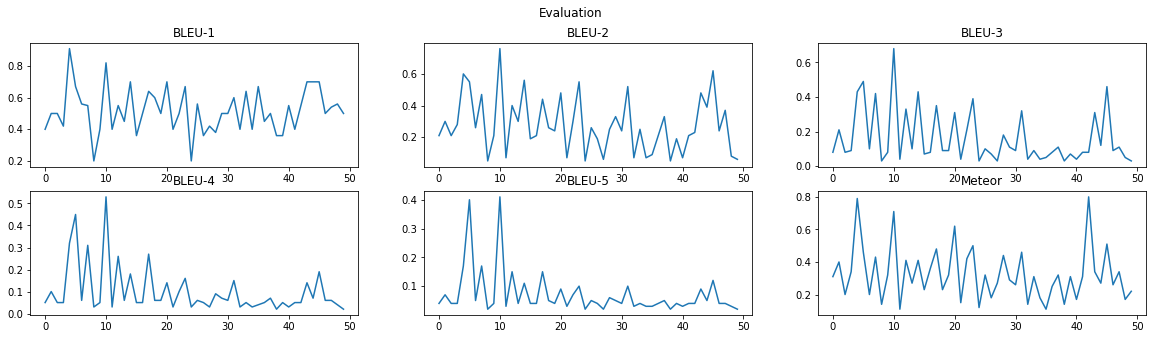

In [64]:
fig, axs = plt.subplots(2, 3)
fig.suptitle('Evaluation')
axs[0, 0].plot(bleu_score_1_vals[:50])
axs[0, 1].plot(bleu_score_2_vals[:50])
axs[0, 2].plot(bleu_score_3_vals[:50])
axs[1, 0].plot(bleu_score_4_vals[:50])
axs[1, 1].plot(bleu_score_5_vals[:50])
axs[1, 2].plot(m_score_vals[:50])
plt.rcParams["figure.figsize"] = (20,5)
axs[0, 0].title.set_text('BLEU-1')
axs[0, 1].title.set_text('BLEU-2')
axs[0, 2].title.set_text('BLEU-3')
axs[1, 0].title.set_text('BLEU-4')
axs[1, 1].title.set_text('BLEU-5')
axs[1, 2].title.set_text('Meteor')
plt.savefig('Training Perplexity')
plt.show()

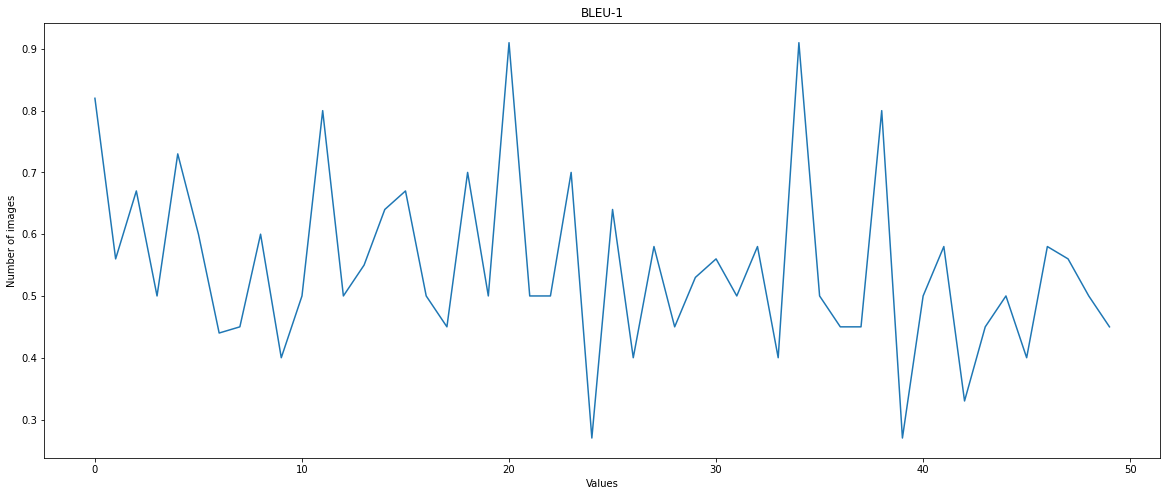

In [377]:
# Plot training perplexity and save figure
plt.plot(bleu_score_1_vals[:50])
plt.rcParams["figure.figsize"] = (20,8)
plt.title('BLEU-1')
plt.xlabel('Values')
plt.ylabel('Number of images')
plt.show()

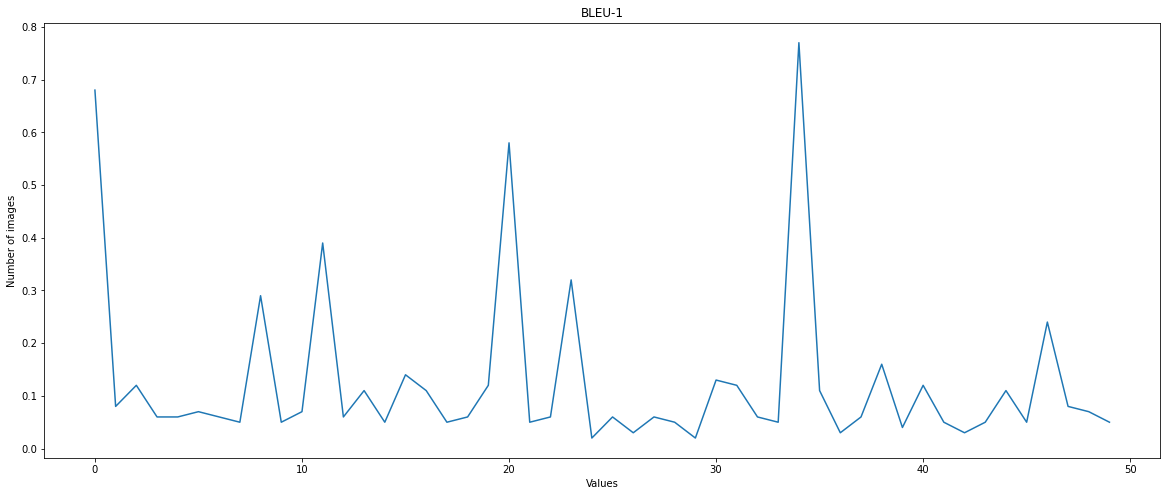

In [380]:
# Plot training perplexity and save figure
plt.plot(bleu_score_4_vals[:50])
plt.rcParams["figure.figsize"] = (20,8)
plt.title('BLEU-1')
plt.xlabel('Values')
plt.ylabel('Number of images')
plt.show()